In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy import interpolate

import os
import time

In [241]:
Ipath = os.getcwd() + "/IforRealNeuron.csv"

Idat = np.genfromtxt(Ipath, delimiter=',')

In [221]:
#Scaling Values
# The scale for V * C should match the scale for I
V_scale = 1e3 # V to mV
C_scale = 1e12 # F to pF

# The scales for I * R should match the scale for V
I_scale = 1e15 # A to fA
R_scale = 1e-12 # O to ...

In [225]:
# Voltages
# Chip bias voltage
V_ref = 1 * V_scale
# Unit Volt(?)
V_unit = 26e-3 * V_scale

# Currents
# Master current(?)
I_master = 1.25e-9 * I_scale
# Voltage(?)
I_voltage = 230e-9 * I_scale
# Reference Current(?)
I_ref = 85e-9 * I_scale
# Injected current scale factor
I_inj_scale = (0.018) * 1e-9 * I_scale

# Capacitances
# Membrane Capacitance
C_m = 4e-12 * C_scale
# Gate capacitance
C_gate = 5e-12 * C_scale

# Resistances
Res = 1.63e6 * R_scale
R_bias = 1.85e6  * R_scale
R_factor = 700e3 * R_scale
R_factor2 = 50e3 * R_scale

# Scale Factors
kappa = 0.7

# Hodgkin Huxley Parameters
g0 = [800, 160, 15] #maximal conductances
e_rev = [300, -210, -190] #reversal potentials in mV

# Scaling H-H parameters for chip
g = np.multiply(g0,(kappa / V_unit) * (I_master / 1024))
E_rev = np.multiply(e_rev,(I_voltage / 1024) * Res) + V_ref


# Conductance Dynamics
vBias = np.zeros(7)
vHigh = V_ref + R_bias * I_voltage
vLow = V_ref - R_bias * I_voltage
I_factor = (vHigh - vLow) / R_factor
vBias[0] = vLow + I_factor * R_factor2

for i in xrange(1,7):
    #[635.2, 756.8, 878.42, 1000, 1121.57, 1243.14, 1364.7] in mV
    vBias[i] = vBias[i - 1] + I_factor * 2*R_factor2 
    
g_f = 1 / (C_gate * V_unit)


In [226]:
am = np.array([0, 0, 120, 400, 800, 1023, 1023]) * I_master / 1024 * g_f
bm = np.array([1023, 1023, 1023, 1023, 0, 0, 0]) * I_master / 1024 * g_f

ah = np.array([237, 80, 0, 0, 0, 0, 0]) * I_master / 1024 * g_f 
bh = np.array([0, 0, 0, 0, 41, 50, 70]) * I_master / 1024 * g_f

an = np.array([0, 0, 0, 0, 18, 5, 43]) * I_master / 1024 * g_f
bn = np.array([1, 0, 0, 1, 0, 0, 1]) * I_master / 1024 * g_f

In [215]:
def sigma(vBiask, V, sign = 1):
    mu = 0.7
    Ut = 26e-3 * V_scale
    return 1 / (1 + np.exp(sign * mu * (vBiask - V) / Ut))



def alpha_spline(V, x, vBias=vBias, am=am, ah=ah, an=an):
    """
    Used to compute the conductance at each time point. 
    The optional arguments default to the parameters defined at the start of the document
    """
    alpha = 0
    for k in np.arange(7):
        if x == "m":
            alpha += am[k] * sigma(vBias[k], V, 1)
        if x == "h":
            alpha += ah[k] * sigma(vBias[k], V, -1)
        if x == "n":
            alpha += an[k] * sigma(vBias[k], V, 1)
    return alpha #* I_master / 1024 * g_f


def beta_spline(V, x, vBias=vBias, bm=bm, bh=bh, bn=bn):
    beta = 0
    for k in np.arange(7):
        if x == "m":
            beta += bm[k] * sigma(vBias[k], V, -1)
        if x == "h":
            beta += bh[k] * sigma(vBias[k], V, 1)
        if x == "n":
            beta += bn[k] * sigma(vBias[k], V, -1)
    return beta #* I_master / 1024 * g_f


Here we define our system as well as the injected current

In [217]:
fIdat = interpolate.interp1d(np.arange(0,len(Idat)), Idat) #Used to interpolate time points that are undefined in Idat

def I_inj(t, scale=I_inj_scale):
    if t * 5e3 <= len(Idat):
        return fIdat(t * 5e3) * scale
    else:
        return 0


def neuron(y, t):
    v, m, h, n = y
    # g = (2.62e-5, 5.25e-6, 4.9e-7)
    # E_rev = (1109, 923, 930.4)
    I_na = g[0] * m**3 * h * (v - E_rev[0])
    I_k = g[1] * n**4 * (v - E_rev[1])
    I_l = g[2] * (v - E_rev[2])
    
    dvdt = (I_inj(t) - I_na - I_l - I_k) / C_m
    dmdt = alpha_spline(v, "m") * (1 - m) - beta_spline(v, "m") * m
    dhdt = alpha_spline(v, "h") * (1 - h) - beta_spline(v, "h") * h
    dndt = alpha_spline(v, "n") * (1 - n) - beta_spline(v, "n") * n
    
    dydt = [dvdt, dmdt, dhdt, dndt]

    return dydt



We set the initial conditions and time window

In [218]:
y0 = [1.09 * V_scale, 0.5 * I_scale / (V_scale * C_scale), 
      0.5 * I_scale / (V_scale * C_scale), 0.5 * I_scale / (V_scale * C_scale)] #initial conditions
t_step = 1e-3
t_max = 4
t = np.linspace(0, t_max, int(t_max / t_step + 1))

start_time = time.time()

sol = odeint(neuron, y0, t, args=())
print "Time elapsed:", time.time() - start_time

Time elapsed: 267.299531937


Plot the data

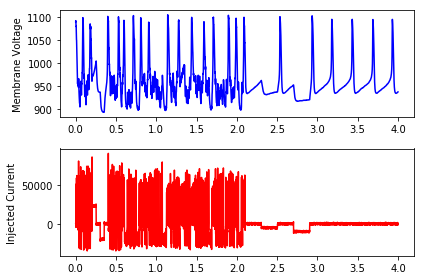

In [219]:
plt.subplot(2,1,1)
plt.plot(t, sol[:,0], 'b')
plt.ylabel('Membrane Voltage')

plt.subplot(2,1,2)
plt.plot(t, fIdat(t * 5e3) * I_inj_scale, 'r')
plt.ylabel('Injected Current')

plt.tight_layout()
plt.show()

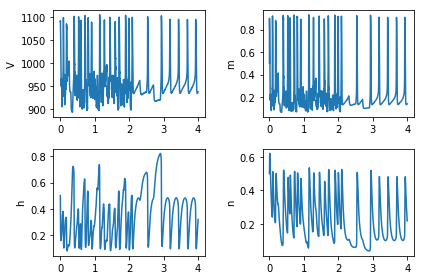

In [232]:
plt.subplot(2,2,1)
plt.plot(t, sol[:,0])
plt.ylabel("V")

plt.subplot(2,2,2)
plt.plot(t, sol[:,1])
plt.ylabel("m")

plt.subplot(2,2,3)
plt.plot(t, sol[:,2])
plt.ylabel("h")

plt.subplot(2,2,4)
plt.plot(t, sol[:,3])
plt.ylabel("n")

plt.tight_layout()
plt.show()

Save data

In [233]:
# add time to data
data = np.insert(sol, 0, t, axis=1)
# add injected current at each time step to data
data = np.insert(data, data.shape[1], fIdat(t * 5e3), axis=1)
# change shape such that time steps are rows
data = data.reshape(len(t),6)
np.save('ode_data.npy', data)